In [1]:
%matplotlib inline


# Face classification using Haar-like feature descriptor


Haar-like feature descriptors were successfully used to implement the first
real-time face detector [1]_. Inspired by this application, we propose an
example illustrating the extraction, selection, and classification of Haar-like
features to detect faces vs. non-faces.

Notes
-----

This example relies on scikit-learn to select and classify features.

References
----------

.. [1] Viola, Paul, and Michael J. Jones. "Robust real-time face
       detection." International journal of computer vision 57.2
       (2004): 137-154.
       http://www.merl.com/publications/docs/TR2004-043.pdf
       DOI: 10.1109/CVPR.2001.990517




In [1]:
from __future__ import division, print_function
from time import time

import numpy as np
import matplotlib.pyplot as plt

from dask import delayed, threaded, multiprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from skimage.data import lfw_subset
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

The usual feature extraction scheme
##############################################################################
 The procedure to extract the Haar-like feature for an image is quite easy: a
 region of interest (ROI) is defined for which all possible feature will be
 extracted. The integral image of this ROI will be computed and all possible
 features will be computed.



In [2]:
@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

We will use a subset of the CBCL which is composed of 100 face images and 100
non-face images. Each image has been resized to a ROI of 19 by 19 pixels. We
will keep 75 images from each group to train a classifier and check which
extracted features are the most salient, and use the remaining 25 from each
class to check the performance of the classifier.



In [3]:
images = lfw_subset()
# For speed, only extract the two first types of features
feature_types = ['type-2-x', 'type-2-y']

# Build a computation graph using dask. This allows using multiple CPUs for
# the computation step
X = delayed(extract_feature_image(img, feature_types)
            for img in images)
# Compute the result using the "multiprocessing" dask backend
t_start = time()
X = np.array(X.compute(get=multiprocessing.get))
time_full_feature_comp = time() - t_start
y = np.array([1] * 100 + [0] * 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)

# Extract all possible features to be able to select the most salient.
feature_coord, feature_type = \
        haar_like_feature_coord(width=images.shape[2], height=images.shape[1],
                                feature_type=feature_types)

/Users/robincole/miniconda3/lib/python3.6/site-packages/dask/base.py:835: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "
/Users/robincole/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


A random forest classifier can be trained in order to select the most salient
features, specifically for face classification. The idea is to check which
features are the most often used by the ensemble of trees. By using only
the most salient features in subsequent steps, we can dramatically speed up
computation, while retaining accuracy.



Text(0.5,0.98,'The most important features')

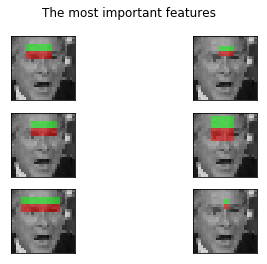

In [4]:
# Train a random forest classifier and check performance
clf = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             max_features=100, n_jobs=-1, random_state=0)
t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

# Sort features in order of importance, plot six most significant
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, axes = plt.subplots(3, 2)
for idx, ax in enumerate(axes.ravel()):
    image = images[0]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('The most important features')

We can select the most important features by checking the cumulative sum of
the feature importance index; below, we keep features representing 70% of the
cumulative value which represent only 3% of the total number of features.



In [5]:
cdf_feature_importances = np.cumsum(clf.feature_importances_[idx_sorted])
cdf_feature_importances /= np.max(cdf_feature_importances)
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.7)
sig_feature_percent = round(sig_feature_count /
                            len(cdf_feature_importances) * 100, 1)
print(('{} features, or {}%, account for 70% of branch points in the random '
       'forest.').format(sig_feature_count, sig_feature_percent))

# Select the most informative features
selected_feature_coord = feature_coord[idx_sorted[:sig_feature_count]]
selected_feature_type = feature_type[idx_sorted[:sig_feature_count]]
# Note: we could select those features from the
# original matrix X but we would like to emphasize the usage of `feature_coord`
# and `feature_type` to recompute a subset of desired features.

# Delay the computation and build the graph using dask
X = delayed(extract_feature_image(img, selected_feature_type,
                                  selected_feature_coord)
            for img in images)
# Compute the result using the *threaded* backend:
# When computing all features, the Python GIL is acquired to process each ROI,
# and this is where most of the time is spent, so multiprocessing is faster.
# For this small subset, most of the time is spent on the feature computation
# rather than the ROI scanning, and using threaded is *much* faster, because
# we avoid the overhead of launching a new process.
t_start = time()
X = np.array(X.compute(get=threaded.get))
time_subs_feature_comp = time() - t_start
y = np.array([1] * 100 + [0] * 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)

724 features, or 0.7%, account for 70% of branch points in the random forest.


/Users/robincole/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Once the features are extracted, we can train and test the a new classifier.



In [7]:
t_start = time()
clf.fit(X_train, y_train)
time_subs_train = time() - t_start

auc_subs_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

summary = (('Computing the full feature set took {:.3f}s, plus {:.3f}s '
            'training, for an AUC of {:.2f}. Computing the restricted feature '
            'set took {:.3f}s, plus {:.3f}s training, for an AUC of {:.2f}.')
           .format(time_full_feature_comp, time_full_train, auc_full_features,
                   time_subs_feature_comp, time_subs_train, auc_subs_features))

print(summary)
plt.show()

Computing the full feature set took 44.232s, plus 1.803s training, for an AUC of 1.00. Computing the restricted feature set took 0.160s, plus 1.305s training, for an AUC of 1.00.
